In [1]:
from pathlib import Path
import subprocess
import numpy as np
import cv2
import rasterio
from rasterio.warp import reproject, Resampling
from math import ceil
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# !conda install -c conda-forge gdal

In [3]:
DATA_ROOT = Path("data")
SCENES_DIR = DATA_ROOT / "UNOSAT-Dataset"
GT_DIR = DATA_ROOT / "UNOSAT-Ground-Truths"

scene_ids = sorted([d.name for d in SCENES_DIR.iterdir() if d.is_dir()])
scene_ids

['S1A_IW_GRDH_1SDV_20180501T025444_20180501T025509_021705_025710_8835',
 'S1A_IW_GRDH_1SDV_20190906T110524_20190906T110549_028900_0346B3_457F',
 'S1A_IW_GRDH_1SDV_20190911T111245_20190911T111310_028973_034937_C91D',
 'S1A_IW_GRDH_1SDV_20190911T111310_20190911T111335_028973_034937_0BA8',
 'S1A_IW_GRDH_1SDV_20190923T111155_20190923T111220_029148_034F2E_9682',
 'S1A_IW_GRDH_1SDV_20190927T225300_20190927T225325_029213_03516D_B4A3',
 'S1A_IW_GRDH_1SDV_20191203T030914_20191203T030939_030178_0372DB_368F',
 'S1B_IW_GRDH_1SDV_20190928T224435_20190928T224504_018244_0225A5_DC47',
 'S1B_IW_GRDH_1SDV_20200120T160700_20200120T160729_019902_025A5F_CDF4']

In [4]:
gt_paths = {p.name.replace("_mask.tif", ""): p for p in GT_DIR.glob("*.tif")}
gt_paths

{'S1A_IW_GRDH_1SDV_20190923T111155_20190923T111220_029148_034F2E_9682': PosixPath('data/UNOSAT-Ground-Truths/S1A_IW_GRDH_1SDV_20190923T111155_20190923T111220_029148_034F2E_9682_mask.tif'),
 'S1A_IW_GRDH_1SDV_20190927T225300_20190927T225325_029213_03516D_B4A3': PosixPath('data/UNOSAT-Ground-Truths/S1A_IW_GRDH_1SDV_20190927T225300_20190927T225325_029213_03516D_B4A3_mask.tif'),
 'S1A_IW_GRDH_1SDV_20191203T030914_20191203T030939_030178_0372DB_368F': PosixPath('data/UNOSAT-Ground-Truths/S1A_IW_GRDH_1SDV_20191203T030914_20191203T030939_030178_0372DB_368F_mask.tif'),
 'S1A_IW_GRDH_1SDV_20180501T025444_20180501T025509_021705_025710_8835': PosixPath('data/UNOSAT-Ground-Truths/S1A_IW_GRDH_1SDV_20180501T025444_20180501T025509_021705_025710_8835_mask.tif'),
 'S1B_IW_GRDH_1SDV_20200120T160700_20200120T160729_019902_025A5F_CDF4': PosixPath('data/UNOSAT-Ground-Truths/S1B_IW_GRDH_1SDV_20200120T160700_20200120T160729_019902_025A5F_CDF4_mask.tif'),
 'S1A_IW_GRDH_1SDV_20190911T111245_20190911T111310_0289

In [5]:
TILE_SIZE = 256
FLAG_VALUE = 0.0  # invalid pixel value in UNOSAT-dataset

def show_tiff(path, title=None, cmap="gray"):
    with rasterio.open(path) as src:
        img = src.read(1)

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title or path)
    plt.axis("off")
    plt.show()

def align_mask_to_vv(vv_path: Path, mask_path: Path) -> np.ndarray:
    with rasterio.open(vv_path) as vv_src, rasterio.open(mask_path) as m_src:
        vv_height, vv_width = vv_src.height, vv_src.width

        mask = m_src.read(1)
        aligned = np.zeros((vv_height, vv_width), dtype=np.uint8)

        print("Reprojecting mask to VV grid...")
        reproject(
            source=mask,
            destination=aligned,
            src_transform=m_src.transform,
            src_crs=m_src.crs,
            dst_transform=vv_src.transform,
            dst_crs=vv_src.crs,
            resampling=Resampling.nearest,
        )
    return aligned

def normalize_to_uint8(arr):
    arr = arr.astype("float32")
    mn, mx = np.percentile(arr, 2), np.percentile(arr, 98)
    arr = np.clip(arr, mn, mx)
    arr = (arr - mn) / (mx - mn + 1e-6)
    return (arr * 255).astype("uint8")

def tile_scene(scene_name: str, vv_path: Path, vh_path: Path, mask_path: Path,
               out_root: Path, region_name: str, datetime_str: str):

    scene_id = f"{region_name}_{datetime_str}"

    vv_dir = out_root / scene_id / "tiles" / "vv"
    vh_dir = out_root / scene_id / "tiles" / "vh"
    fl_dir = out_root / scene_id / "tiles" / "label"

    for d in (vv_dir, vh_dir, fl_dir):
        d.mkdir(parents=True, exist_ok=True)

    # 1. Load compressed VV & VH (already Byte).
    with rasterio.open(vv_path) as src_vv, \
         rasterio.open(vh_path) as src_vh:

        vv = src_vv.read(1)
        vh = src_vh.read(1)

    # show_tiff(vv_path, title="VV Polarization")
    # show_tiff(vh_path, title="VH Polarization")
    # show_tiff(mask_path, title="Flood Mask", cmap="gray")

    # 2. Align mask to VV grid (reproject).
    mask = align_mask_to_vv(vv_path, mask_path)
    
    print(f"VV path: {vv_path}, shape: {vv.shape}")
    print(f"VH path: {vh_path}, shape: {vh.shape}")
    print(f"Mask path: {mask_path}, shape: {mask.shape}")

    assert vv.shape == vh.shape == mask.shape , "VV, VH, and mask must have the same shape."

    H, W = vv.shape
    n_tiles_y = ceil(H / TILE_SIZE)
    n_tiles_x = ceil(W / TILE_SIZE)

    # 3. Tile the VV, VH, and mask images.
    for iy in range(n_tiles_y):
        for ix in range(n_tiles_x):

            y0, x0 = iy * TILE_SIZE, ix * TILE_SIZE
            y1, x1 = min(y0 + TILE_SIZE, H), min(x0 + TILE_SIZE, W)

            vv_crop = vv[y0:y1, x0:x1]
            vh_crop = vh[y0:y1, x0:x1]
            mask_crop = mask[y0:y1, x0:x1]

            # # drop tiles containing frame / invalid flag
            if np.any(vv_crop == FLAG_VALUE):
                continue

            if np.any(vh_crop == FLAG_VALUE):
                continue

            # require at least 1 flood pixel
            if np.sum(mask_crop) == 0:
                continue

            vv_norm = normalize_to_uint8(vv_crop)
            vh_norm = normalize_to_uint8(vh_crop)

            # pad to TILE_SIZE
            vv_pad = np.zeros((TILE_SIZE, TILE_SIZE), dtype=np.uint8)
            vh_pad = np.zeros_like(vv_pad)
            mask_pad = np.zeros_like(vv_pad)

            vv_pad[:vv_norm.shape[0], :vv_norm.shape[1]] = vv_norm
            vh_pad[:vh_norm.shape[0], :vh_norm.shape[1]] = vh_norm
            mask_pad[:mask_crop.shape[0], :mask_crop.shape[1]] = mask_crop

            base = f"{scene_id}_x-{ix}_y-{iy}"

            cv2.imwrite(str(vv_dir / f"{base}_vv.png"), vv_pad)
            cv2.imwrite(str(vh_dir / f"{base}_vh.png"), vh_pad)

            # binarize mask to 0/255
            mask_bin = (mask_pad > 0).astype(np.uint8) * 255
            cv2.imwrite(str(fl_dir / f"{base}.png"), mask_bin)

In [7]:
OUT_ROOT = Path("data/final-UNOSAT-Dataset")
OUT_ROOT.mkdir(exist_ok=True, parents=True)

regions_in_order = [
    "somalia",
    "vietnam",
    "thailand",
    "thailand",
    "cambodia",
    "cambodia",
    "mozambique",
    "myanmar",
    "vietnam",
    "mozambique"
]

def gdal_translate(in_path, out_path, band):
    cmd = [
        "gdal_translate",
        "-ot", "Byte",
        "-co", "COMPRESS=JPEG",
        "-b", str(band),
        str(in_path),
        str(out_path),
    ]
    print("Running:", " ".join(cmd))
    try:
        subprocess.run(cmd, check=True)
    except Exception as e:
        print("Error running gdal_translate:", e)
    
for i, scene_id in tqdm(list(enumerate(scene_ids)), total=len(scene_ids), desc="Scenes"):
    print("\n" + "="*40)
    print(f"Processing scene: {scene_id}")

    parts = scene_id.split("_")
    dt = parts[4]  # e.g., "20190911T111245"

    # locate original UNOSAT scene directory
    scene_dir = SCENES_DIR / scene_id

    # find VV and VH original tiff files (your naming convention)
    vv_path_raw = next(scene_dir.glob("*VV*.tif*"))
    vh_path_raw = next(scene_dir.glob("*VH*.tif*"))

    # # prepare output paths for 8-bit converted images
    # byte_dir = Path("data/compressed-UNOSAT-Dataset") / scene_id
    # byte_dir.mkdir(exist_ok=True, parents=True)

    # vv_byte = byte_dir / f"{scene_id}_VV.tif"
    # vh_byte = byte_dir / f"{scene_id}_VH.tif"

    # # run GDAL translate
    # gdal_translate(vv_path_raw, vv_byte, band=1)
    # gdal_translate(vh_path_raw, vh_byte, band=1)

    # with rasterio.open(vv_byte) as src:
    #     img = src.read(1)

    #     plt.figure(figsize=(6, 6))
    #     plt.imshow(img, cmap="gray")
    #     plt.title(vv_byte)
    #     plt.axis("off")
    #     plt.show()

    # get corresponding mask
    mask_path = gt_paths[scene_id]

    # tile into ETCI-style tiles
    tile_scene(
        scene_name=scene_id,
        vv_path=vv_path_raw,
        vh_path=vh_path_raw,
        mask_path=mask_path,
        out_root=OUT_ROOT,
        region_name=regions_in_order[i],
        datetime_str=dt
    )
    print(f"Finished tiling scene: {scene_id}")
    print("="*40)
    
print("\nDone! All scenes processed.")

Scenes:   0%|          | 0/9 [00:00<?, ?it/s]


Processing scene: S1A_IW_GRDH_1SDV_20180501T025444_20180501T025509_021705_025710_8835
Reprojecting mask to VV grid...
VV path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20180501T025444_20180501T025509_021705_025710_8835/S1A_IW_20180501T025444_DVP_RTC10_G_gpuned_9ECC_VV.tif, shape: (22025, 28378)
VH path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20180501T025444_20180501T025509_021705_025710_8835/S1A_IW_20180501T025444_DVP_RTC10_G_gpuned_9ECC_VH.tif, shape: (22025, 28378)
Mask path: data/UNOSAT-Ground-Truths/S1A_IW_GRDH_1SDV_20180501T025444_20180501T025509_021705_025710_8835_mask.tif, shape: (22025, 28378)


Scenes:  11%|█         | 1/9 [00:19<02:38, 19.79s/it]

Finished tiling scene: S1A_IW_GRDH_1SDV_20180501T025444_20180501T025509_021705_025710_8835

Processing scene: S1A_IW_GRDH_1SDV_20190906T110524_20190906T110549_028900_0346B3_457F
Reprojecting mask to VV grid...
VV path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20190906T110524_20190906T110549_028900_0346B3_457F/S1A_IW_20190906T110524_DVP_RTC10_G_gpuned_1ABC_VV.tif, shape: (21707, 28698)
VH path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20190906T110524_20190906T110549_028900_0346B3_457F/S1A_IW_20190906T110524_DVP_RTC10_G_gpuned_1ABC_VH.tif, shape: (21707, 28698)
Mask path: data/UNOSAT-Ground-Truths/S1A_IW_GRDH_1SDV_20190906T110524_20190906T110549_028900_0346B3_457F_mask.tif, shape: (21707, 28698)


Scenes:  22%|██▏       | 2/9 [00:34<01:59, 17.04s/it]

Finished tiling scene: S1A_IW_GRDH_1SDV_20190906T110524_20190906T110549_028900_0346B3_457F

Processing scene: S1A_IW_GRDH_1SDV_20190911T111245_20190911T111310_028973_034937_C91D
Reprojecting mask to VV grid...
VV path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20190911T111245_20190911T111310_028973_034937_C91D/S1A_IW_20190911T111245_DVP_RTC10_G_gpuned_9E94_VV.tif, shape: (21605, 28513)
VH path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20190911T111245_20190911T111310_028973_034937_C91D/S1A_IW_20190911T111245_DVP_RTC10_G_gpuned_9E94_VH.tif, shape: (21605, 28513)
Mask path: data/UNOSAT-Ground-Truths/S1A_IW_GRDH_1SDV_20190911T111245_20190911T111310_028973_034937_C91D_mask.tif, shape: (21605, 28513)


Scenes:  33%|███▎      | 3/9 [01:04<02:17, 22.91s/it]

Finished tiling scene: S1A_IW_GRDH_1SDV_20190911T111245_20190911T111310_028973_034937_C91D

Processing scene: S1A_IW_GRDH_1SDV_20190911T111310_20190911T111335_028973_034937_0BA8
Reprojecting mask to VV grid...
VV path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20190911T111310_20190911T111335_028973_034937_0BA8/S1A_IW_20190911T111310_DVP_RTC10_G_gpuned_1629_VV.tif, shape: (21515, 28411)
VH path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20190911T111310_20190911T111335_028973_034937_0BA8/S1A_IW_20190911T111310_DVP_RTC10_G_gpuned_1629_VH.tif, shape: (21515, 28411)
Mask path: data/UNOSAT-Ground-Truths/S1A_IW_GRDH_1SDV_20190911T111310_20190911T111335_028973_034937_0BA8_mask.tif, shape: (21515, 28411)


Scenes:  44%|████▍     | 4/9 [01:36<02:11, 26.39s/it]

Finished tiling scene: S1A_IW_GRDH_1SDV_20190911T111310_20190911T111335_028973_034937_0BA8

Processing scene: S1A_IW_GRDH_1SDV_20190923T111155_20190923T111220_029148_034F2E_9682
Reprojecting mask to VV grid...
VV path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20190923T111155_20190923T111220_029148_034F2E_9682/S1A_IW_20190923T111155_DVP_RTC10_G_gpuned_AA77_VV.tif, shape: (21752, 28611)
VH path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20190923T111155_20190923T111220_029148_034F2E_9682/S1A_IW_20190923T111155_DVP_RTC10_G_gpuned_AA77_VH.tif, shape: (21752, 28611)
Mask path: data/UNOSAT-Ground-Truths/S1A_IW_GRDH_1SDV_20190923T111155_20190923T111220_029148_034F2E_9682_mask.tif, shape: (21752, 28611)


Scenes:  56%|█████▌    | 5/9 [02:03<01:45, 26.48s/it]

Finished tiling scene: S1A_IW_GRDH_1SDV_20190923T111155_20190923T111220_029148_034F2E_9682

Processing scene: S1A_IW_GRDH_1SDV_20190927T225300_20190927T225325_029213_03516D_B4A3
Reprojecting mask to VV grid...
VV path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20190927T225300_20190927T225325_029213_03516D_B4A3/S1A_IW_20190927T225300_DVP_RTC10_G_gpuned_243F_VV.tif, shape: (21682, 28187)
VH path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20190927T225300_20190927T225325_029213_03516D_B4A3/S1A_IW_20190927T225300_DVP_RTC10_G_gpuned_243F_VH.tif, shape: (21682, 28187)
Mask path: data/UNOSAT-Ground-Truths/S1A_IW_GRDH_1SDV_20190927T225300_20190927T225325_029213_03516D_B4A3_mask.tif, shape: (21682, 28187)


Scenes:  67%|██████▋   | 6/9 [02:24<01:14, 24.87s/it]

Finished tiling scene: S1A_IW_GRDH_1SDV_20190927T225300_20190927T225325_029213_03516D_B4A3

Processing scene: S1A_IW_GRDH_1SDV_20191203T030914_20191203T030939_030178_0372DB_368F
Reprojecting mask to VV grid...
VV path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20191203T030914_20191203T030939_030178_0372DB_368F/S1A_IW_20191203T030914_DVP_RTC10_G_gpuned_25EB_VV.tif, shape: (23188, 29392)
VH path: data/UNOSAT-Dataset/S1A_IW_GRDH_1SDV_20191203T030914_20191203T030939_030178_0372DB_368F/S1A_IW_20191203T030914_DVP_RTC10_G_gpuned_25EB_VH.tif, shape: (23188, 29392)
Mask path: data/UNOSAT-Ground-Truths/S1A_IW_GRDH_1SDV_20191203T030914_20191203T030939_030178_0372DB_368F_mask.tif, shape: (23188, 29392)


Scenes:  78%|███████▊  | 7/9 [02:41<00:44, 22.27s/it]

Finished tiling scene: S1A_IW_GRDH_1SDV_20191203T030914_20191203T030939_030178_0372DB_368F

Processing scene: S1B_IW_GRDH_1SDV_20190928T224435_20190928T224504_018244_0225A5_DC47
Reprojecting mask to VV grid...
VV path: data/UNOSAT-Dataset/S1B_IW_GRDH_1SDV_20190928T224435_20190928T224504_018244_0225A5_DC47/S1B_IW_20190928T224435_DVP_RTC10_G_gpuned_58DD_VV.tif, shape: (24275, 28579)
VH path: data/UNOSAT-Dataset/S1B_IW_GRDH_1SDV_20190928T224435_20190928T224504_018244_0225A5_DC47/S1B_IW_20190928T224435_DVP_RTC10_G_gpuned_58DD_VH.tif, shape: (24275, 28579)
Mask path: data/UNOSAT-Ground-Truths/S1B_IW_GRDH_1SDV_20190928T224435_20190928T224504_018244_0225A5_DC47_mask.tif, shape: (24275, 28579)


Scenes:  89%|████████▉ | 8/9 [03:11<00:24, 24.62s/it]

Finished tiling scene: S1B_IW_GRDH_1SDV_20190928T224435_20190928T224504_018244_0225A5_DC47

Processing scene: S1B_IW_GRDH_1SDV_20200120T160700_20200120T160729_019902_025A5F_CDF4
Reprojecting mask to VV grid...
VV path: data/UNOSAT-Dataset/S1B_IW_GRDH_1SDV_20200120T160700_20200120T160729_019902_025A5F_CDF4/S1B_IW_20200120T160700_DVP_RTC10_G_gpuned_F186_VV.tif, shape: (25179, 29538)
VH path: data/UNOSAT-Dataset/S1B_IW_GRDH_1SDV_20200120T160700_20200120T160729_019902_025A5F_CDF4/S1B_IW_20200120T160700_DVP_RTC10_G_gpuned_F186_VH.tif, shape: (25179, 29538)
Mask path: data/UNOSAT-Ground-Truths/S1B_IW_GRDH_1SDV_20200120T160700_20200120T160729_019902_025A5F_CDF4_mask.tif, shape: (25179, 29538)


Scenes: 100%|██████████| 9/9 [03:28<00:00, 23.19s/it]

Finished tiling scene: S1B_IW_GRDH_1SDV_20200120T160700_20200120T160729_019902_025A5F_CDF4

Done! All scenes processed.


Scenes:   0%|          | 0/9 [00:00<?, ?it/s]

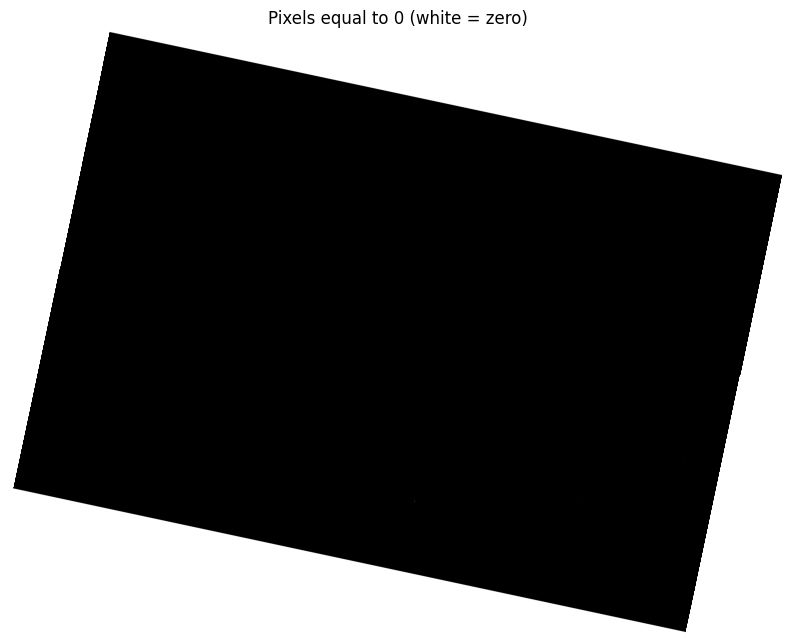

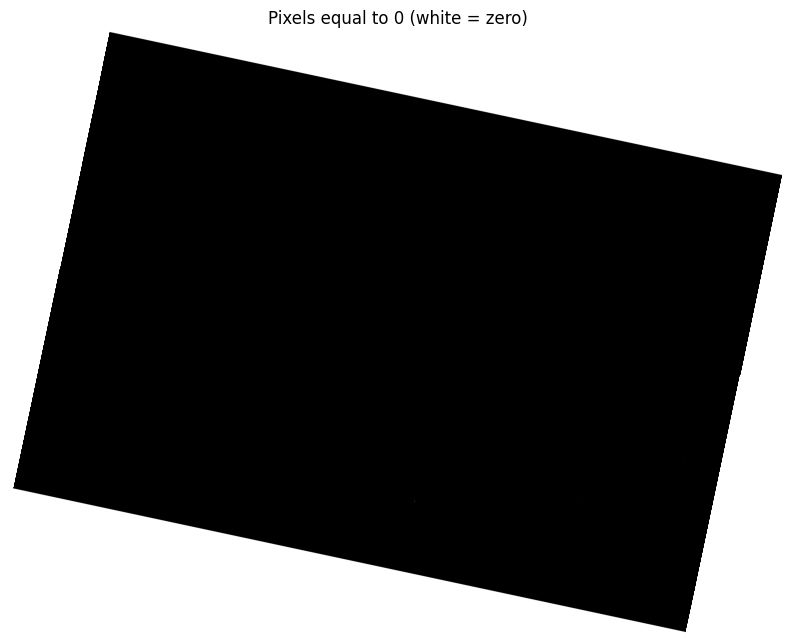

Scenes: 100%|██████████| 9/9 [01:48<00:00, 12.09s/it] 


In [ ]:
def inspect_raster(path):
    with rasterio.open(path) as src:
        arr = src.read(1)
        nodata = src.nodata

    print("File:", path)
    print("Declared nodata:", nodata)
    print("Min:", arr.min())
    print("Max:", arr.max())

    # Count how many exact zeros
    print("Zero pixels:", np.sum(arr == 0))

    # Print the 20 most common pixel values
    vals, counts = np.unique(arr, return_counts=True)
    idx = np.argsort(counts)[-20:]  # top 20
    print("Most frequent pixel values:")
    for v, c in zip(vals[idx], counts[idx]):
        print(f"  value={v}, count={c}")

def show_zero_mask(tif_path):
    with rasterio.open(tif_path) as src:
        img = src.read(1)

    zero_mask = (img == 0)

    plt.figure(figsize=(10, 8))
    plt.imshow(zero_mask, cmap='gray')
    plt.title("Pixels equal to 0 (white = zero)")
    plt.axis("off")
    plt.show()

### SANITY CHECK: TESTING CODE TO INSPECT ZERO PIXELS IN RAW TIFFs ###
for i, scene_id in tqdm(list(enumerate(scene_ids)), total=len(scene_ids), desc="Scenes"):
    # locate original UNOSAT scene directory
    if i == 0:  # only inspect the first scene for brevity
        scene_dir = SCENES_DIR / scene_id

        # find VV and VH original tiff files (your naming convention)
        vv_path_raw = next(scene_dir.glob("*VV*.tif*"))
        vh_path_raw = next(scene_dir.glob("*VH*.tif*"))

        # inspect_raster(vv_path_raw)
        # inspect_raster(vh_path_raw)

        show_zero_mask(vv_path_raw)
        show_zero_mask(vh_path_raw)

        # get corresponding mask
        mask_path = gt_paths[scene_id]

In [ ]:
import random
from collections import defaultdict

### SANITY CHECK:  ###
def show_random_tile(scene_dir: Path):
    vv_dir = scene_dir / "tiles" / "vv"
    vh_dir = scene_dir / "tiles" / "vh"
    mask_dir = scene_dir / "tiles" / "label"

    vv_files = sorted(vv_dir.glob("*_vv.png"))
    if not vv_files:
        print("No VV tiles found.")
        return

    # pick a random tile
    vv_tile = random.choice(vv_files)
    base = vv_tile.name.replace("_vv.png", "")
    vh_tile = vh_dir / f"{base}_vh.png"
    mask_tile = mask_dir / f"{base}.png"

    # load images
    vv = cv2.imread(str(vv_tile), cv2.IMREAD_UNCHANGED)
    vh = cv2.imread(str(vh_tile), cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(str(mask_tile), cv2.IMREAD_UNCHANGED)

    # display all 3
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(vv, cmap='gray'); plt.title("VV"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(vh, cmap='gray'); plt.title("VH"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(mask, cmap='gray'); plt.title("Mask"); plt.axis("off")
    plt.show()

def count_tiles_per_scene(root):
    root = Path(root)
    counts = {}

    for scene_dir in root.iterdir():
        if not scene_dir.is_dir():
            continue

        vv_tiles = list((scene_dir/"tiles"/"vv").glob("*.png"))
        vh_tiles = list((scene_dir/"tiles"/"vh").glob("*.png"))
        mask_tiles = list((scene_dir/"tiles"/"label").glob("*.png"))

        counts[scene_dir.name] = {
            "vv": len(vv_tiles),
            "vh": len(vh_tiles),
            "mask": len(mask_tiles)
        }

    return counts

def compute_flood_stats(root):
    root = Path(root)
    total_pixels = 0
    flood_pixels = 0

    for scene_dir in root.iterdir():
        mask_dir = scene_dir / "tiles" / "label"
        for mask_path in mask_dir.glob("*.png"):
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            mask_bin = (mask > 127).astype(np.uint8)

            total_pixels += mask_bin.size
            flood_pixels += np.sum(mask_bin)

    flood_ratio = flood_pixels / total_pixels
    return flood_ratio, flood_pixels, total_pixels

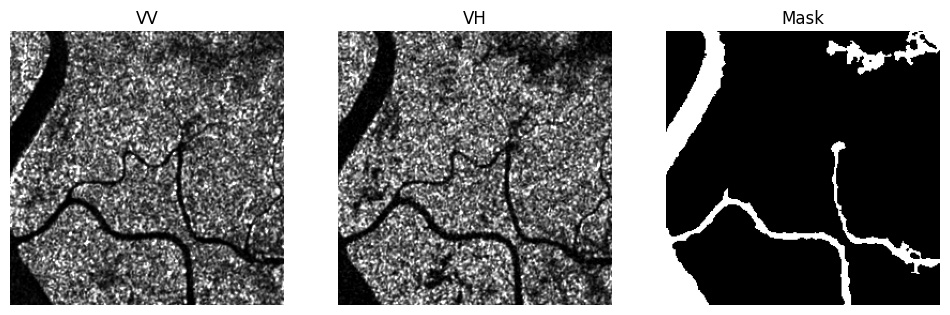

In [10]:
# 1. Visually inspect a few tiles (VV, VH, mask).
scene_folder = random.choice(list(OUT_ROOT.iterdir()))
show_random_tile(scene_folder)

In [11]:
# 2. Count number of tiles per scene
counts = count_tiles_per_scene(OUT_ROOT)
counts

{'vietnam_20190906T110524': {'vv': 1322, 'vh': 1322, 'mask': 1322},
 'thailand_20190911T111245': {'vv': 5557, 'vh': 5557, 'mask': 5557},
 'myanmar_20190928T224435': {'vv': 5189, 'vh': 5189, 'mask': 5189},
 'cambodia_20190923T111155': {'vv': 4566, 'vh': 4566, 'mask': 4566},
 'cambodia_20190927T225300': {'vv': 3079, 'vh': 3079, 'mask': 3079},
 'vietnam_20200120T160700': {'vv': 1300, 'vh': 1300, 'mask': 1300},
 'somalia_20180501T025444': {'vv': 1975, 'vh': 1975, 'mask': 1975},
 'mozambique_20191203T030914': {'vv': 2119, 'vh': 2119, 'mask': 2119},
 'thailand_20190911T111310': {'vv': 5849, 'vh': 5849, 'mask': 5849}}

In [12]:
# 3. Compute flood pixel statistics
ratio, flood_px, total_px = compute_flood_stats(OUT_ROOT)
ratio

np.float64(0.1482179648870953)